# Pullback Strategy Research Notebook

In [1]:
import pandas as pd, numpy as np
import sys, os

sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Scripts'))
from indicators import *
from parameters import *
from func import *
from ohlcv import *

# Suppresses SettingWithCopyWarning in Pandas
pd.options.mode.chained_assignment = None  # default='warn'

## Getting OHLC data

In [2]:
# ohlcv = collectOHLCV('EUR_USD', start=time_before_now(weeks=52), 
#                      granularity='M1')
# ohlcv.to_csv('../ohlc/EURUSD_{}_{}.csv'.format(str(ohlcv.index[0]).split(' ')[0],
#                                                str(ohlcv.index[-1]).split(' ')[0]))

In [3]:
ohlcv = pd.read_csv('../ohlc/EURUSD_2010-08-08_2018-07-27.csv', 
                    index_col='time')

In [312]:
#ohlcv = ohlcv + 0.00007 # for duka only

In [323]:
# Parameter Overrides
Pip_Diff_SL = 15
risk = 1

In [ ]:
halfspr = 0.00007

# Indicator setup
indic = pd.DataFrame()

indic['Don_S_H'] = Donchian_H(ohlcv.high, Don_SX)
indic['Don_S_L'] = Donchian_L(ohlcv.low, Don_SX)
indic['Don_L_H'] = Donchian_H(ohlcv.high, Don_S)
indic['Don_L_L'] = Donchian_L(ohlcv.low, Don_S)
indic['Don_H_M'] = (lambda x, y: (x+y)/2)(
    Donchian_H(ohlcv.high, Don_L),
    Donchian_L(ohlcv.low, Don_L)
)

indic['MACD_Hist'] = MACD_Hist(ohlcv.close, *MACD_param)
indic['SMA_Diff']  = MA_Cross(ohlcv.close, SMA_Fast, SMA_Slow)

indic['Buy_Chan']  = indic.Don_L_L > indic.Don_H_M
indic['Sell_Chan'] = indic.Don_L_H < indic.Don_H_M


 #+--------------------------------------+

# Long Signal
longSig = pd.DataFrame(index=ohlcv.index)

longSig['Stop'] = np.where(indic.MACD_Hist.shift(1) < 0,
                           indic.Don_L_H.shift(1) + Pip_Diff*0.0001, 
                           None)
longSig['Stop'].fillna(method='ffill', inplace = True)

longSig['Sig'] = np.where((ohlcv.high + halfspr) > longSig.Stop, 1, 0)
longSig['Sig'] = np.where(longSig.Stop > ohlcv.open, longSig.Sig, 0)
longSig['Sig'] = np.where(indic.SMA_Diff.shift(1) > 0, longSig.Sig, 0)
longSig['Sig'] = np.where(indic.Buy_Chan.shift(1), longSig.Sig, 0)

longSig['InitialSL'] = indic.Don_S_L.shift(1) - Pip_Diff_SL*0.0001
longSig['InitialSL'] = np.where((longSig.Stop - longSig.InitialSL) > Pip_Diff_SL*0.0001,
                                 longSig.InitialSL, longSig.Stop - Pip_Diff_SL*0.0001)

# MACD Pullback region
longSig['macd'] = np.where((indic.MACD_Hist.shift(2) > 0) & (indic.MACD_Hist.shift(1) < 0), 1, 0)
longSig['macd'] = longSig['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
longSig.loc[longSig.Sig == 0, 'Sig'] = None

# longSig['Sig'] = np.where(longSig['macd'].shift(1) == longSig['macd'], 
#                           np.where(longSig['Sig'].shift(1) == 1,None, longSig['Sig']),
#                          np.where((longSig['macd'].shift(1) != longSig['macd']) & (longSig['Sig'] == 1),
#                                  longSig['Sig'], 0))

longSig['Sig'] = np.where(longSig['macd'].shift(1) == longSig['macd'], 
                          np.where(longSig['Sig'].shift(1) == 1,None, longSig['Sig']), 0)


longSig['Sig'].fillna(method='ffill', inplace=True)

#longSig['Sig'] = np.where(longSig['Sig'].shift(1) + longSig['Sig'] == 2 ,0, longSig['Sig'])

longSig['Sig'] = np.where((longSig['Sig'] == 1) & (longSig['macd'].shift(1) == longSig['macd']), 
                          np.where(longSig['Sig'].shift(1) + longSig['Sig'] == 2 ,0, longSig['Sig']), 0)




longSig['SigPrice'] = np.where(longSig.Sig == 1, longSig.Stop, 0)

longSig['StopLoss'] = np.where((ohlcv.low + halfspr) < longSig.InitialSL,
                               longSig.InitialSL, None)
longSig['StopLoss'].fillna(method='bfill', inplace=True)


longSig['Closed'] = np.where(longSig.StopLoss == None, False, True)

# Replaced Close Price to current InitialSL
longSig['StopLoss'].fillna(value=longSig.InitialSL.iloc[-1], inplace=True)
longSig['StopLoss'] = np.where(longSig.InitialSL > longSig.StopLoss,
                               longSig.InitialSL,  longSig.StopLoss)

# Trade Duration
longSig['SLtime'] = pd.to_datetime(
    np.where((ohlcv.low + halfspr) < longSig.InitialSL, longSig.index, None)
)
longSig['SLtime'].fillna(method='bfill', inplace=True)
longSig['SLtime'].fillna(value=longSig.index[-1], inplace=True)
longSig['SLtime'] = np.where(longSig.InitialSL > longSig.StopLoss,
                             longSig.index,  longSig.SLtime)
#+--------------------------------------+

# Short Signal
shortSig = pd.DataFrame(index=ohlcv.index)

shortSig['Stop'] = np.where(indic.MACD_Hist.shift(1) > 0,
                            indic.Don_L_L.shift(1) - Pip_Diff*0.0001, None)
shortSig['Stop'].fillna(method='ffill', inplace = True)

shortSig['Sig'] = np.where((ohlcv.low - halfspr) < shortSig.Stop, 1, 0)
shortSig['Sig'] = np.where(shortSig.Stop < ohlcv.open, shortSig.Sig, 0)

shortSig['Sig'] = np.where(indic.SMA_Diff.shift(1) < 0, shortSig.Sig, 0)
shortSig['Sig'] = np.where(indic.Sell_Chan.shift(1), shortSig.Sig, 0)

shortSig['InitialSL'] = indic.Don_S_H.shift(1) + Pip_Diff_SL*0.0001
shortSig['InitialSL'] = np.where(shortSig.InitialSL - shortSig.Stop > Pip_Diff_SL*0.0001,
                                 shortSig.InitialSL, shortSig.Stop + Pip_Diff_SL*0.0001)


# MACD Pullback region
shortSig['macd'] = np.where((indic.MACD_Hist.shift(2) < 0) & (indic.MACD_Hist.shift(1) > 0), 1, 0) # this is the same as longsig macd condi
shortSig['macd'] = shortSig['macd'].cumsum()

# Unstacking such that limit to one trade per macd region
shortSig.loc[shortSig.Sig == 0, 'Sig'] = None

# shortSig['Sig'] = np.where(shortSig['macd'].shift(1) == shortSig['macd'], 
#                            np.where(shortSig['Sig'].shift(1) == 1,None, shortSig['Sig']), 
#                            np.where((shortSig['macd'].shift(1) != shortSig['macd']) & (shortSig['Sig'] == 1),
#                                  shortSig['Sig'], 0))
shortSig['Sig'] = np.where(shortSig['macd'].shift(1) == shortSig['macd'], 
                           np.where(shortSig['Sig'].shift(1) == 1,None, shortSig['Sig']), 0)

shortSig['Sig'].fillna(method='ffill', inplace=True)

#shortSig['Sig'] = np.where(shortSig['Sig'].shift(1) + shortSig['Sig'] == 2,0, shortSig['Sig'])
shortSig['Sig'] = np.where((shortSig['Sig'] == 1) & (shortSig['macd'].shift(1) == shortSig['macd']), 
                           np.where(shortSig['Sig'].shift(1) + shortSig['Sig'] == 2,0, shortSig['Sig']), 0)


shortSig['SigPrice'] = np.where(shortSig.Sig == 1, shortSig.Stop, 0)

shortSig['StopLoss'] = np.where((ohlcv.high - halfspr) > shortSig.InitialSL,
                               shortSig.InitialSL, None)
shortSig['StopLoss'].fillna(method='bfill', inplace=True)

shortSig['Closed'] = np.where(shortSig.StopLoss == None, False, True)

# Replaced Close Price to current InitialSL
shortSig['StopLoss'].fillna(value=shortSig.InitialSL.iloc[-1], inplace=True)
shortSig['StopLoss'] = np.where(shortSig.InitialSL < shortSig.StopLoss,
                                shortSig.InitialSL,  shortSig.StopLoss)

# Trade Duration
shortSig['SLtime'] = pd.to_datetime(
    np.where((ohlcv.high - halfspr) > shortSig.InitialSL, shortSig.index, None)
)
shortSig['SLtime'].fillna(method='bfill', inplace=True)
shortSig['SLtime'].fillna(value=shortSig.index[-1], inplace=True)
shortSig['SLtime'] = np.where(shortSig.InitialSL < shortSig.StopLoss,
                                shortSig.index,  shortSig.SLtime)
#+--------------------------------------+

# Strategy
strat = pd.DataFrame(index=ohlcv.index)

strat['Sig'] = np.where(longSig.Sig,
                        longSig.Sig,
                        np.where(shortSig.Sig,
                                 shortSig.Sig, 0))

strat['Units'] = np.where(longSig.Sig,
                          (risk/(longSig.SigPrice - \
                                 longSig.InitialSL)),
                          0)
strat['Units'] = np.where(shortSig.Sig,
                          (risk/(shortSig.SigPrice - \
                                 shortSig.InitialSL)),
                          strat.Units)
strat['Units'] = strat.Units.astype(np.int)

strat['SigPrice'] = np.where(longSig.Sig, longSig.SigPrice,
                             np.where(shortSig.Sig, shortSig.SigPrice,
                                      0))
strat['StopLoss'] = np.where(longSig.Sig, longSig.StopLoss,
                             np.where(shortSig.Sig, shortSig.StopLoss,
                                      0))
strat['InitialSL'] = np.where(longSig.Sig, longSig.InitialSL,
                             np.where(shortSig.Sig, shortSig.InitialSL,
                                      0))

strat['BuyProfits'] = np.where(
    longSig.Sig,
    (longSig.StopLoss - longSig.SigPrice)*strat.Units, 0
)
strat['SellProfits'] = np.where(
    shortSig.Sig,
    (shortSig.StopLoss - shortSig.SigPrice)*strat.Units, 0
)
strat['Profits'] = strat.BuyProfits + strat.SellProfits

strat['Closed'] = np.where(longSig.Sig, longSig.Closed,
                           np.where(shortSig.Sig, shortSig.Closed,
                                    None))
strat.loc[longSig.Sig == True, 
          'SLtime'] = longSig.loc[longSig.Sig == True, 
                                  'SLtime']
strat.loc[shortSig.Sig == True, 
          'SLtime'] = shortSig.loc[shortSig.Sig == True,
                                   'SLtime']

strat = strat[(strat.Sig == 1)]
print('We have populated {} simulated trades.'.format(strat.shape[0]))


In [ ]:
strategy = strat.Profits
strategycs = strategy.cumsum()

df_PS = pd.DataFrame(strategycs)
df_PS.columns = ['Equity']
#df_PS.Equity = df_PS.Equity + 1

# counting a complete loss series
df_PS['PnL'] = strategy
df_PS['Series'] = np.where((df_PS['PnL'].shift(1) <0) & (df_PS['PnL'] >0), 1, 0)

# rolling max drawdown
df_PS['Peak'] = df_PS.Equity.cummax()
df_PS['diff'] = df_PS.Peak - df_PS.Equity 
df_PS['Drawdown'] = df_PS['diff'].rolling(30).max() # rolling window

del df_PS['Equity']


#plt.figure()
#df_PS.Drawdown.plot()

In [326]:
# Drawdown hits 15%, resets at 10%
df_PS['Thres1'] = np.where(df_PS.Drawdown.shift(1) > 0.15, 1, 
                           np.where((df_PS.Drawdown.shift(1) < 0.1) & \
                                    (df_PS.Drawdown.shift(2) > 0.1), 0, None))
df_PS['Thres1'].fillna(method='ffill', inplace=True) 


df_PS['DDthreshold'] = df_PS['Thres1']


df_PS['DDEQ'] = np.where(df_PS.DDthreshold == 1, strat.Profits * 0.5, strat.Profits)
df_PS['NewCumSum_5']= df_PS.DDEQ.cumsum()

In [327]:
# chance of occurence
df_PS[df_PS.Drawdown > 200].shape[0]/df_PS.shape[0]

0.0

In [328]:
import matplotlib.pyplot as plt
%matplotlib inline

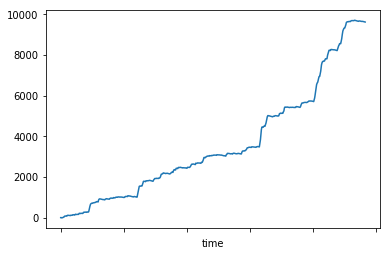

In [329]:
plt.figure()
#(strat['Profits']).cumsum().plot()
(df_PS.NewCumSum_5).plot()

In [330]:
#Annual return
annualReturn = (strat.Profits).cumsum().iloc[-1]/8/10
print('Annual returns: {}%'.format(annualReturn))
#Max absolute DD
absoluteDD = Drawdown((strat.Profits).cumsum()).max()/10
print('DD: {}%'.format(absoluteDD))
#MAR
MAR = annualReturn/absoluteDD
print('MAR: {}'.format(MAR))

Annual returns: 180.59908275%
DD: 17.697457999999642%
MAR: 10.20480357970075


In [331]:
#Annual return
annualReturn = df_PS.NewCumSum_5.iloc[-1]/8/10
print('Annual returns: {}%'.format(annualReturn))
#Max absolute DD
absoluteDD = Drawdown(df_PS.NewCumSum_5).max()/10
print('DD: {}%'.format(absoluteDD))
#MAR
MAR = annualReturn/absoluteDD
print('MAR: {}'.format(MAR))

Annual returns: 120.25928731249985%
DD: 8.848729000000457%
MAR: 13.590571856420695


In [322]:
#strat.to_csv('../Results/BasicEURUSDH1.csv')

In [257]:
import plotly.offline as py
import plotly.graph_objs as go

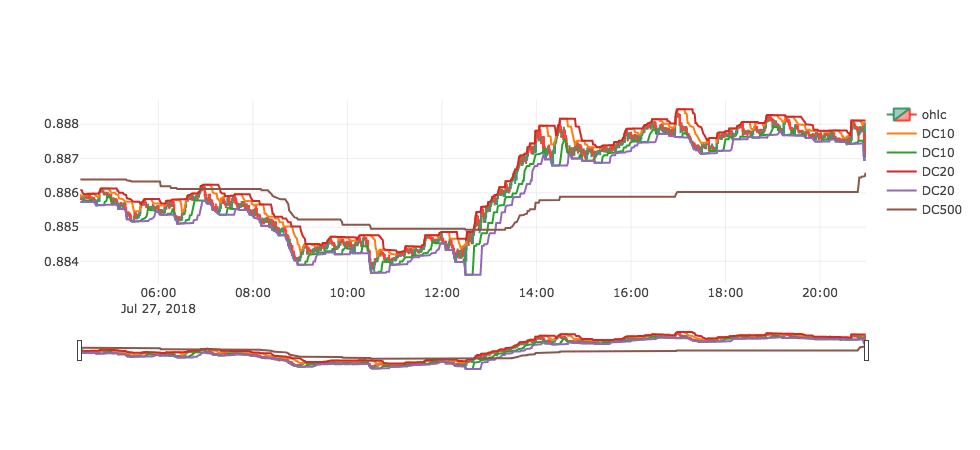

In [258]:
a = -1000

trace0 = go.Candlestick(x = ohlcv[a:].index,
                      open = ohlcv[a:].open,
                      high = ohlcv[a:].high,
                      low = ohlcv[a:].low,
                      close = ohlcv[a:].close,
                       name = 'ohlc')

trace1 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_S_H,
                   name = 'DC10')
trace2 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_S_L,
                   name = 'DC10')
trace3 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_L_H,
                   name = 'DC20')
trace4 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_L_L,
                   name = 'DC20')
trace5 = go.Scatter(x = ohlcv[a:].index,
                   y = indic[a:].Don_H_M,
                   name = 'DC500')



data = [trace0, trace1, trace2, trace3, trace4, trace5]



py.iplot(data, filename='Candlestick')